In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_complete_animation(sim, filename="covid_complete_simulation.gif", show_animation=True):
    """
    Animation simplifiée : retour aux bases avec une meilleure visibilité
    """
    
    # Créer la figure avec layout simplifié
    fig = plt.figure(figsize=(18, 10))
    
    # Graphique 3D (gauche)
    ax3d = fig.add_subplot(231, projection='3d')
    ax3d.set_xlim(0, 100)
    ax3d.set_ylim(0, 100)
    ax3d.set_zlim(0, 100)
    ax3d.set_xlabel('X')
    ax3d.set_ylabel('Y')
    ax3d.set_zlabel('Z')
    ax3d.set_title('Propagation spatiale 3D')
    ax3d.view_init(elev=25, azim=45)
    
    # Graphique 2D des courbes SEIR (centre gauche)
    ax_seir = fig.add_subplot(234)
    ax_seir.set_xlim(0, sim.days)
    ax_seir.set_ylim(0, sim.N)
    ax_seir.set_xlabel('Jours')
    ax_seir.set_ylabel('Population')
    ax_seir.set_title('Évolution SEIR')
    ax_seir.grid(True, alpha=0.3)
    
    # Graphique des nouvelles infections (centre droit)
    ax_infections = fig.add_subplot(235)
    ax_infections.set_xlim(0, sim.days)
    ax_infections.set_ylim(0, sim.N//3)
    ax_infections.set_xlabel('Jours')
    ax_infections.set_ylabel('Nouvelles infections/jour')
    ax_infections.set_title('Infections quotidiennes')
    ax_infections.grid(True, alpha=0.3)
    
    # Graphique des proportions (bas droit)
    ax_pie = fig.add_subplot(236)
    ax_pie.set_title('Répartition actuelle')
    ax_pie.axis('equal')
    
    # Zone pour les statistiques (haut droit)
    ax_stats = fig.add_subplot(232)
    ax_stats.axis('off')
    ax_stats.set_title('Statistiques')
    
    # Couleurs
    colors = ['#3498db', '#f1c40f', '#e74c3c', '#2ecc71']
    labels = ['Susceptibles', 'Exposés', 'Infectieux', 'Rétablis']
    
    # Initialiser les scatter plots 3D
    scatters = []
    for i in range(4):
        scatter = ax3d.scatter([], [], [], 
                              c=colors[i], 
                              s=35 if i == 2 else 30,
                              alpha=0.8, 
                              label=labels[i],
                              edgecolor='black' if i == 2 else 'none',
                              linewidth=0.5)
        scatters.append(scatter)
    
    # Initialiser les courbes SEIR
    lines = []
    for i, (color, label) in enumerate(zip(colors, labels)):
        line, = ax_seir.plot([], [], color=color, linewidth=3, label=label)
        lines.append(line)
    
    # Texte d'information simple et propre
    info_text = ax_stats.text(0.05, 0.95, '', transform=ax_stats.transAxes,
                           verticalalignment='top', fontsize=10,
                           fontfamily='monospace')
    
    # Légende pour les courbes SEIR
    ax_seir.legend(loc='upper right', fontsize=9)
    
    # Zone de confinement
    if sim.scenario == "confinement":
        ax_seir.axvspan(15, 35, alpha=0.2, color='gray')
        ax_infections.axvspan(15, 35, alpha=0.2, color='gray')
    
    # Fonction d'initialisation
    def init():
        for scatter in scatters:
            scatter._offsets3d = ([], [], [])
        for line in lines:
            line.set_data([], [])
        
        ax_infections.clear()
        ax_infections.set_xlim(0, sim.days)
        ax_infections.set_ylim(0, sim.N//3)
        ax_infections.set_xlabel('Jours')
        ax_infections.set_ylabel('Nouvelles infections/jour')
        ax_infections.set_title('Infections quotidiennes')
        ax_infections.grid(True, alpha=0.3)
        
        info_text.set_text('Initialisation...')
        
        # Initialiser le camembert
        ax_pie.clear()
        ax_pie.set_title('Répartition initiale')
        ax_pie.pie([sim.N, 0, 0, 0], labels=labels, colors=colors, autopct='%1.0f%%')
        
        return scatters + lines + [info_text]
    
    # Calculer le nombre de frames nécessaires
    total_frames = int(sim.days * sim.fps)
    frames_to_use = min(total_frames, 400)  # Limite raisonnable
    
    print(f"Création de l'animation: {frames_to_use} frames ({sim.days} jours)")
    
    # CORRECTION IMPORTANTE : S'assurer que la simulation a assez de données
    # Continuer la simulation si nécessaire
    while len(sim.history['S']) < frames_to_use:
        sim.step()
        if len(sim.history['S']) % 50 == 0:
            print(f"  Simulation: {len(sim.history['S'])}/{frames_to_use} frames")
    
    # Fonction d'animation CORRIGÉE
    def update(frame):
        # Pour les frames après la simulation existante, on utilise les données existantes
        if frame >= len(sim.history['S']):
            return scatters + lines + [info_text]
        
        current_day = frame / sim.fps
        
        # 1. MISE À JOUR GRAPHIQUE 3D
        if frame < len(sim.history['positions']):
            positions = sim.history['positions'][frame]
            states = np.zeros(sim.N, dtype=int)
            
            # Reconstruire les états à partir de l'historique
            S_count = sim.history['S'][frame] if frame < len(sim.history['S']) else 0
            E_count = sim.history['E'][frame] if frame < len(sim.history['E']) else 0
            I_count = sim.history['I'][frame] if frame < len(sim.history['I']) else 0
            R_count = sim.history['R'][frame] if frame < len(sim.history['R']) else 0
            
            # Assigner les états (simplifié)
            idx = 0
            for _ in range(S_count):
                if idx < sim.N:
                    states[idx] = 0
                    idx += 1
            for _ in range(E_count):
                if idx < sim.N:
                    states[idx] = 1
                    idx += 1
            for _ in range(I_count):
                if idx < sim.N:
                    states[idx] = 2
                    idx += 1
            for _ in range(R_count):
                if idx < sim.N:
                    states[idx] = 3
                    idx += 1
            
            for state in range(4):
                mask = (states == state)
                if np.any(mask):
                    pos = positions[mask]
                    scatters[state]._offsets3d = (pos[:, 0], pos[:, 1], pos[:, 2])
        
        # 2. MISE À JOUR COURBES SEIR (TOUJOURS VISIBLES)
        time_points = np.arange(len(sim.history['S'])) / sim.fps
        
        # Limiter aux données disponibles
        max_idx = min(len(time_points), len(sim.history['S']), 
                     len(sim.history['E']), len(sim.history['I']), 
                     len(sim.history['R']))
        
        if max_idx > 0:
            time_points = time_points[:max_idx]
            
            # CORRECTION : Mettre à jour TOUTES les courbes
            lines[0].set_data(time_points, sim.history['S'][:max_idx])  # S
            lines[1].set_data(time_points, sim.history['E'][:max_idx])  # E
            lines[2].set_data(time_points, sim.history['I'][:max_idx])  # I
            lines[3].set_data(time_points, sim.history['R'][:max_idx])  # R
            
            # Ajuster les limites Y dynamiquement
            max_pop = max(np.max(sim.history['S'][:max_idx]), 
                         np.max(sim.history['E'][:max_idx]),
                         np.max(sim.history['I'][:max_idx]),
                         np.max(sim.history['R'][:max_idx]))
            ax_seir.set_ylim(0, max(10, max_pop * 1.1))
        
        # 3. MISE À JOUR INFECTIONS QUOTIDIENNES
        ax_infections.clear()
        
        if len(sim.history['new_infections']) > 1:
            # S'assurer qu'on a assez de données de temps
            infection_frames = min(len(sim.history['new_infections']), len(time_points) + 1)
            
            if infection_frames > 1:
                infection_times = time_points[:infection_frames-1]
                infection_values = sim.history['new_infections'][1:infection_frames]
                
                # Barres simples
                bars = ax_infections.bar(infection_times, infection_values, 
                                       color='#e74c3c', alpha=0.7, width=0.8/sim.fps)
                
                # Moyenne mobile si assez de données
                if len(infection_values) > 7:
                    window = 7
                    moving_avg = np.convolve(infection_values, 
                                           np.ones(window)/window, mode='valid')
                    valid_times = infection_times[window-1:]
                    ax_infections.plot(valid_times, moving_avg, 
                                     color='#c0392b', linewidth=2, label='Moyenne 7j')
                
                if sim.scenario == "confinement":
                    ax_infections.axvspan(15, 35, alpha=0.2, color='gray')
                
                ax_infections.set_xlim(0, sim.days)
                max_inf = max(5, np.max(infection_values) * 1.2) if len(infection_values) > 0 else 10
                ax_infections.set_ylim(0, max_inf)
                ax_infections.set_xlabel('Jours')
                ax_infections.set_ylabel('Nouvelles infections/jour')
                ax_infections.set_title('Infections quotidiennes')
                ax_infections.grid(True, alpha=0.3)
                
                if len(infection_values) > 7:
                    ax_infections.legend(loc='upper right')
        
        # 4. MISE À JOUR CAMEMBERT
        ax_pie.clear()
        
        if frame < len(sim.history['S']):
            current_values = [
                sim.history['S'][frame],
                sim.history['E'][frame],
                sim.history['I'][frame],
                sim.history['R'][frame]
            ]
            
            # Filtrer les valeurs nulles
            pie_data = []
            pie_labels_local = []
            pie_colors_local = []
            
            for val, lab, col in zip(current_values, labels, colors):
                if val > 0:
                    pie_data.append(val)
                    pie_labels_local.append(lab)
                    pie_colors_local.append(col)
            
            if sum(pie_data) > 0:
                ax_pie.pie(pie_data, labels=pie_labels_local, colors=pie_colors_local,
                          autopct=lambda p: f'{p:.0f}%' if p > 5 else '',
                          startangle=90)
        
        ax_pie.set_title(f'Jour {current_day:.1f}')
        
        # 5. MISE À JOUR STATISTIQUES (simple et propre)
        if frame < len(sim.history['S']):
            stats_text = f"Jour: {current_day:.1f} / {sim.days}\n"
            stats_text += f"Scénario: {sim.scenario}\n"
            stats_text += "─" * 20 + "\n"
            stats_text += f"S: {sim.history['S'][frame]} ({sim.history['S'][frame]/sim.N*100:.1f}%)\n"
            stats_text += f"E: {sim.history['E'][frame]}\n"
            stats_text += f"I: {sim.history['I'][frame]} ({sim.history['I'][frame]/sim.N*100:.1f}%)\n"
            stats_text += f"R: {sim.history['R'][frame]} ({sim.history['R'][frame]/sim.N*100:.1f}%)\n"
            stats_text += "─" * 20 + "\n"
            
            # Calculer R0 effectif si possible
            if frame > 0 and sim.history['I'][frame-1] > 0:
                try:
                    beta_effective = sim.beta_current
                    R_eff = beta_effective / sim.gamma
                    stats_text += f"R₀ effectif: {R_eff:.2f}"
                except:
                    pass
        else:
            stats_text = f"Jour: {current_day:.1f} / {sim.days}\nSimulation terminée"
        
        info_text.set_text(stats_text)
        
        # 6. ROTATION DE LA VUE 3D
        ax3d.view_init(elev=25, azim=45 + frame * 0.3)
        
        return scatters + lines + [info_text]
    
    # Ajuster l'espacement
    plt.subplots_adjust(wspace=0.25, hspace=0.3)
    
    # Créer l'animation
    print("Génération de l'animation...")
    
    # Utiliser exactement le nombre de frames disponibles
    actual_frames = min(frames_to_use, len(sim.history['S']))
    
    anim = FuncAnimation(fig, update, frames=actual_frames,
                        init_func=init, blit=False, interval=1000/sim.fps)
    
    # Sauvegarde en GIF
    if filename.endswith('.gif'):
        print(f"Sauvegarde en GIF ({actual_frames} frames)...")
        try:
            writer = PillowWriter(fps=sim.fps//2)  # FPS réduit de moitié pour GIF
            anim.save(filename, writer=writer, dpi=100)
            print(f"✓ GIF sauvegardé: {filename}")
        except Exception as e:
            print(f"✗ Erreur: {e}")
            print("Affichage à l'écran seulement...")
    
    if show_animation:
        plt.tight_layout()
        plt.show()
    else:
        plt.close(fig)
    
    return anim, sim

SIMULATION COVID-19 3D - VERSION CORRIGEE
Tous les agents restent visibles pendant toute la simulation
Simulation initialisee:
   - 120 agents, 40 jours
   - 8 infectes initiaux
   - R0 initial: 3.50
Création de l'animation: 400 frames (40 jours)
  Simulation: 50/400 frames
  Simulation: 100/400 frames
  Simulation: 150/400 frames
  Simulation: 200/400 frames
  Simulation: 250/400 frames
  Simulation: 300/400 frames
  Simulation: 350/400 frames
  Simulation: 400/400 frames
Génération de l'animation...
Sauvegarde en GIF (400 frames)...


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

✓ GIF sauvegardé: covid_confinement_complete.gif


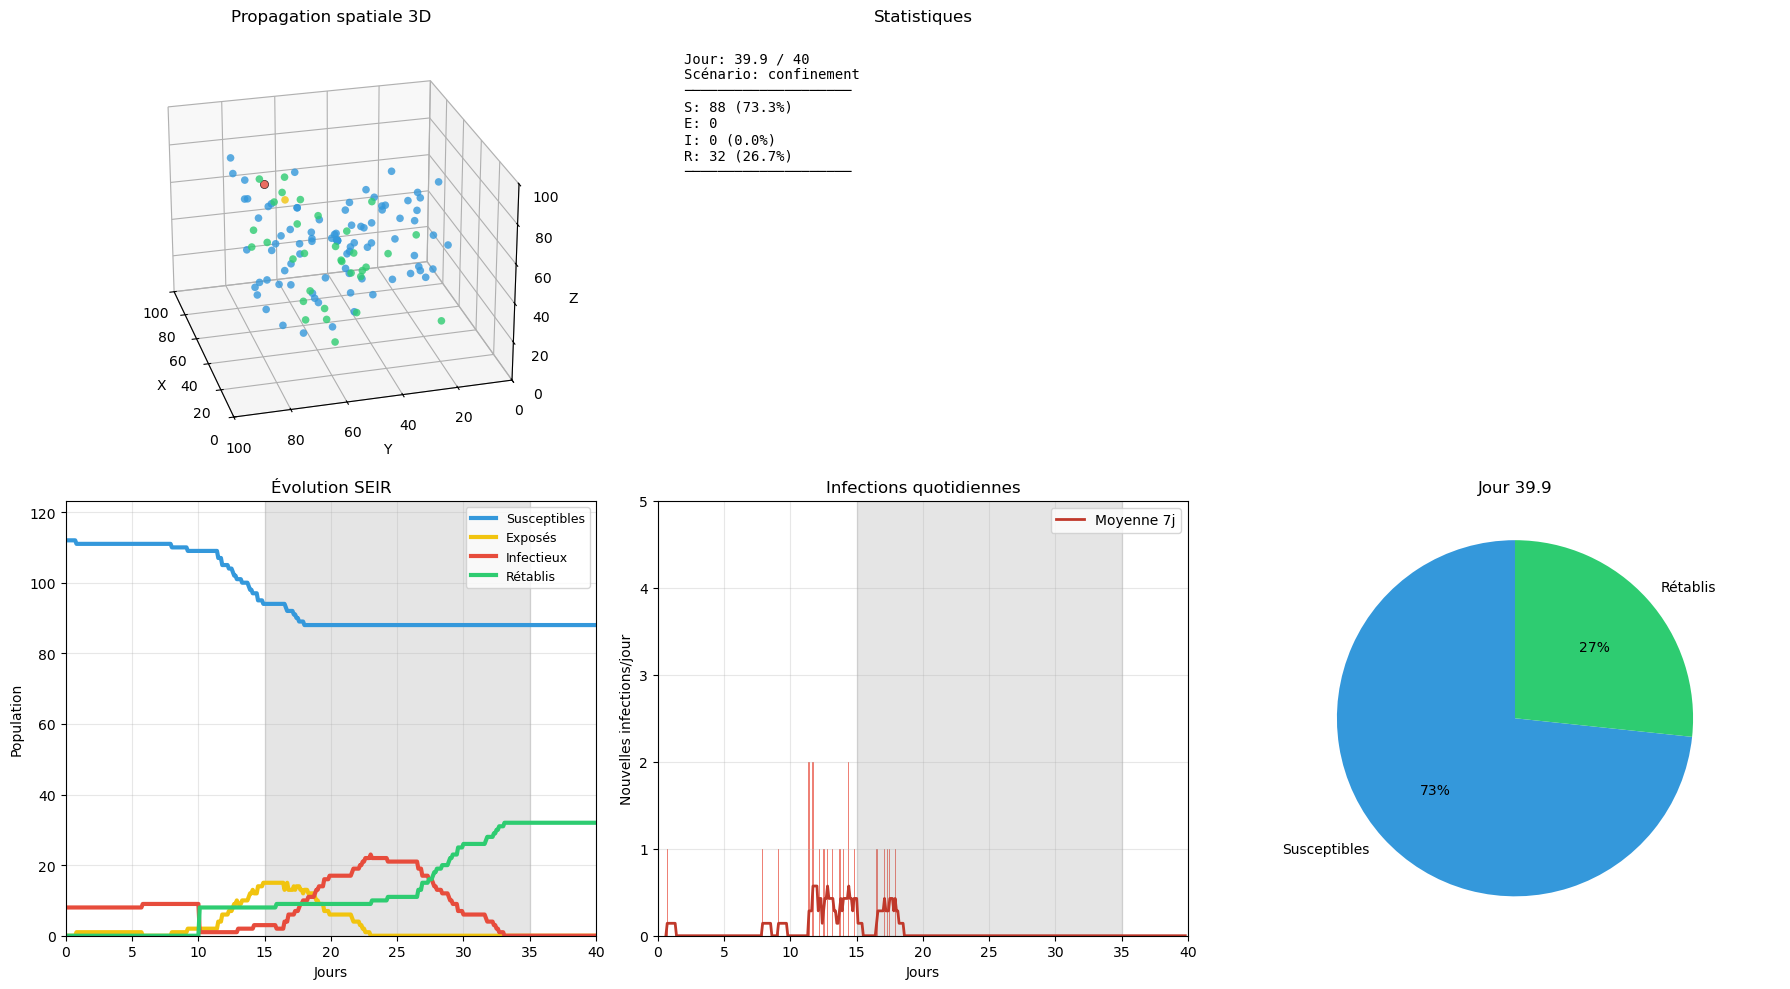


STATISTIQUES FINALES:
Scenario: confinement
Population totale: 120
Susceptibles finaux: 88
Exposes finaux: 0
Infectieux finaux: 0
Retablis finaux: 32
Verification total: 120 (devrait etre 120)
SUCCES: Tous les agents sont bien comptabilises!


In [15]:
if __name__ == "__main__":
    print("="*70)
    print("SIMULATION COVID-19 3D - VERSION CORRIGEE")
    print("Tous les agents restent visibles pendant toute la simulation")
    print("="*70)
    
    # Choisir le scenario
    scenario_choice = "confinement"  # Testez avec "base", "confinement", etc.
    
    # Creer la simulation
    sim = SimulationSEIR3D(N=120, days=40, fps=10)
    sim.scenario = scenario_choice
    
    # Lancer l'animation
    anim, final_sim = create_complete_animation(
        sim, 
        filename=f"covid_{scenario_choice}_complete.gif",
        show_animation=True
    )
    
    # Statistiques finales
    print("\n" + "="*70)
    print("STATISTIQUES FINALES:")
    print("="*70)
    print(f"Scenario: {final_sim.scenario}")
    print(f"Population totale: {final_sim.N}")
    print(f"Susceptibles finaux: {final_sim.history['S'][-1]}")
    print(f"Exposes finaux: {final_sim.history['E'][-1]}")
    print(f"Infectieux finaux: {final_sim.history['I'][-1]}")
    print(f"Retablis finaux: {final_sim.history['R'][-1]}")
    
    total_check = (final_sim.history['S'][-1] + final_sim.history['E'][-1] + 
                   final_sim.history['I'][-1] + final_sim.history['R'][-1])
    print(f"Verification total: {total_check} (devrait etre {final_sim.N})")
    
    if total_check == final_sim.N:
        print("SUCCES: Tous les agents sont bien comptabilises!")
    else:
        print("ERREUR: Certains agents ont ete perdus!")